In [8]:
%%capture
!pip install datasets
!pip install certifi

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

### Get SQL queries

In [28]:
import os
import os.path
import ssl
import stat
import subprocess
import sys

STAT_0o775 = ( stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR
             | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP
             | stat.S_IROTH |                stat.S_IXOTH )


def main():
    openssl_dir, openssl_cafile = os.path.split(
        ssl.get_default_verify_paths().openssl_cafile)

    print(" -- pip install --upgrade certifi")
    subprocess.check_call([sys.executable,
        "-E", "-s", "-m", "pip", "install", "--upgrade", "certifi"])

    import certifi

    # change working directory to the default SSL directory
    os.chdir(openssl_dir)
    relpath_to_certifi_cafile = os.path.relpath(certifi.where())
    print(" -- removing any existing file or link")
    try:
        os.remove(openssl_cafile)
    except FileNotFoundError:
        pass
    print(" -- creating symlink to certifi certificate bundle")
    os.symlink(relpath_to_certifi_cafile, openssl_cafile)
    print(" -- setting permissions")
    os.chmod(openssl_cafile, STAT_0o775)
    print(" -- update complete")

main()


# os.environ['REQUESTS_CA_BUNDLE'] = '/Users/ESMoraEn/repositories/DigiCert TLS Hybrid ECC SHA384 2020 CA1.cer'

 -- pip install --upgrade certifi
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete


In [24]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
from datasets import load_dataset

sql = load_dataset('wikisql', split='test')

Using the latest cached version of the module from /Users/ESMoraEn/.cache/huggingface/modules/datasets_modules/datasets/wikisql/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d (last modified on Wed Jun 14 12:10:40 2023) since it couldn't be found locally at wikisql., or remotely on the Hugging Face Hub.


HF google storage unreachable. Downloading and preparing it from source


ConnectionError: Couldn't reach https://github.com/salesforce/WikiSQL/raw/master/data.tar.bz2 (SSLError(MaxRetryError("HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /salesforce/WikiSQL/raw/master/data.tar.bz2 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get issuer certificate (_ssl.c:997)')))")))

In [ ]:
sql = sql['sql'].sample(len(sql), random_state=1113)[:1000]
sql = [x['human_readable'] for x in sql]
print(sql[:10])
print(len(sql))

In [ ]:
train_sql = sql.copy()

In [ ]:
import pandas as pd

test_df = pd.DataFrame({'sql_sentence': test_sql})
test_df.to_csv('test_df.csv', index=False)

In [ ]:
pd.read_csv('test_df.csv').shape

(15878, 1)

### Get sentences

In [ ]:
sentences = load_dataset('glue', 'stsb', split='test')
print(sentences.shape)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


(1379, 4)


In [ ]:
sentences = sentences.shuffle(seed=1113)['sentence1'][:1000]
print(sentences[:10])

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-b566652a2a364b60.arrow


['Storm buries Northeast; 16 inches of snow in NJ', "You don't have to know.", 'A girl is playing guitar.', "I don't think it makes any tremendous difference.", 'Militant attack from Afghanistan kills four in Upper Dir', 'The New York senator\'s new book, "Living History," appears a certain bestseller.', "I think it's fine to ask this question.", 'Schiphol airport partly evacuated after bomb threat', 'Syria fighting rages as Russia urges Western re-think', 'Nigeria mourns over 193 people killed in plane crash']


### Generate dataset

In [ ]:
import pandas as pd 
import numpy as np

data = pd.DataFrame({'sentence': sql+sentences, 'is_sql': np.concatenate((np.ones(1000), np.zeros(1000)))})
data.shape

(2000, 2)

In [ ]:
data.iloc[995:1005]

,sentence,is_sql
995,SELECT N° FROM table WHERE Television service ...,1.0
996,SELECT SUM Grid FROM table WHERE Laps = 30 AND...,1.0
997,SELECT Position FROM table WHERE Player = kenn...,1.0
998,SELECT Event FROM table WHERE Score points = 10,1.0
999,SELECT Date FROM table WHERE Opponent in the f...,1.0
1000,Storm buries Northeast; 16 inches of snow in NJ,0.0
1001,You don't have to know.,0.0
1002,A girl is playing guitar.,0.0
1003,I don't think it makes any tremendous difference.,0.0
1004,Militant attack from Afghanistan kills four in...,0.0


### Get embeddings

In [1]:
%%capture 
!pip install transformers

In [2]:
from transformers import RobertaTokenizer, RobertaModel
  
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
tokenizer.save_pretrained('.')
model.save_pretrained('.')

In [4]:
%%capture
!pip install sentence-transformers

In [5]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('.', max_seq_length=15)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [51]:
import pandas as pd

data_sql = pd.read_csv('data/wikiSQL/train_sql.csv')
data_sql.dropna(inplace=True)
data_sql['sqli'] = '0'
data_sql = data_sql.iloc[0:1000]
data_sql.head()
print(data_sql.shape)

(1000, 2)


In [52]:
data_sqli = pd.read_csv('data/sqli/sqliv2.csv', encoding='utf-16')
data_sqli.dropna(inplace=True)
data_sqli.rename(columns = {'Sentence': 'sql_sentence'}, inplace = True)
data_sqli['sqli'] = '1'
data_sqli.drop(['Label'], axis=1, inplace=True)
data_sqli = data_sqli.iloc[0:1000]
data_sqli.head()

,sql_sentence,sqli
1,""" or pg_sleep ( __TIME__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
5,select * from users where id = '1' or @ @1 = ...,1


<AxesSubplot: >

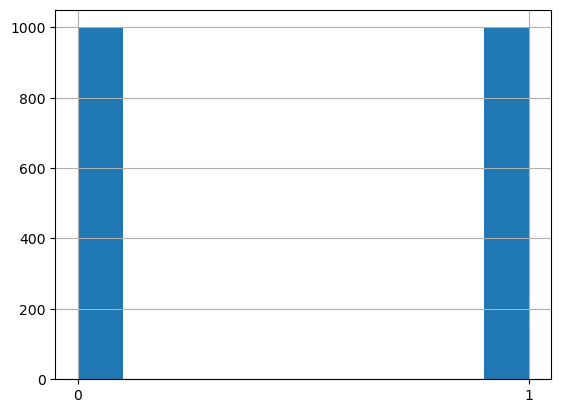

In [53]:
data = pd.concat([data_sql, data_sqli], ignore_index=True)
data['sqli'].hist()

In [37]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cpu


In [38]:
data.head()

,sql_sentence,sqli
0,SELECT Notes FROM table WHERE Current slogan =...,0
1,SELECT Current series FROM table WHERE Notes =...,0
2,SELECT Format FROM table WHERE State/territory...,0
3,SELECT Text/background colour FROM table WHERE...,0
4,SELECT COUNT Fleet Series (Quantity) FROM tabl...,0


In [28]:
output = model.encode(data['sql_sentence'].tolist()[0])
print(output)

[-3.13129015e-02 -1.17420748e-01 -3.92757691e-02  1.55090153e-01
  5.90124577e-02  1.84879392e-01 -5.43268956e-02 -2.15998050e-02
  1.24925621e-01  9.01639275e-03 -2.87114829e-01 -1.88388713e-02
  3.18995044e-02 -1.12989925e-01  8.32462236e-02 -9.69102159e-02
 -6.36612028e-02 -5.64153716e-02  5.51141053e-02  2.91574568e-01
  4.68801074e-02  7.12016597e-02  2.07112115e-02  5.74591011e-02
 -2.85458475e-01 -3.94662432e-02  4.35463339e-02  4.55318354e-02
 -1.64133534e-02  2.85810560e-01 -9.64784324e-02  7.00300857e-02
  2.18345914e-02 -4.27755620e-03 -1.64834142e-03  7.61287436e-02
  3.39042433e-02  1.97409932e-02  7.62050375e-02 -1.92758702e-02
 -8.59623216e-03 -5.47524206e-02 -6.67702854e-02  7.29716942e-02
  6.02803677e-02 -1.12169618e-02 -1.31138191e-01  1.09080821e-01
 -9.23446566e-02  2.93286089e-02 -8.18382427e-02  1.46888822e-01
 -9.76199433e-02  1.81133039e-02 -9.44182128e-02  6.86696768e-02
 -2.50738580e-02  9.02587175e-02  1.11631244e-01  3.63264866e-02
  3.95303331e-02  6.61466

In [39]:
input = tokenizer(data['sql_sentence'].tolist()[0], return_tensors="pt", padding=True).to(device)
output = model.encode(data['sql_sentence'].tolist()[0])
outputs = torch.from_numpy(output)
outputs = outputs.unsqueeze(0)

for i in range(1, len(data)):
    output = model.encode(data['sql_sentence'].tolist()[i])
    output = torch.from_numpy(output)
    output = output.unsqueeze(0)
    outputs = torch.cat((outputs, output), 0)

In [40]:
outputs.shape

torch.Size([2000, 768])

In [41]:
from sklearn.manifold import TSNE

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(outputs)
tsne_result.shape

(2000, 2)

In [61]:
data['sqli'].values.shape

(2000,)

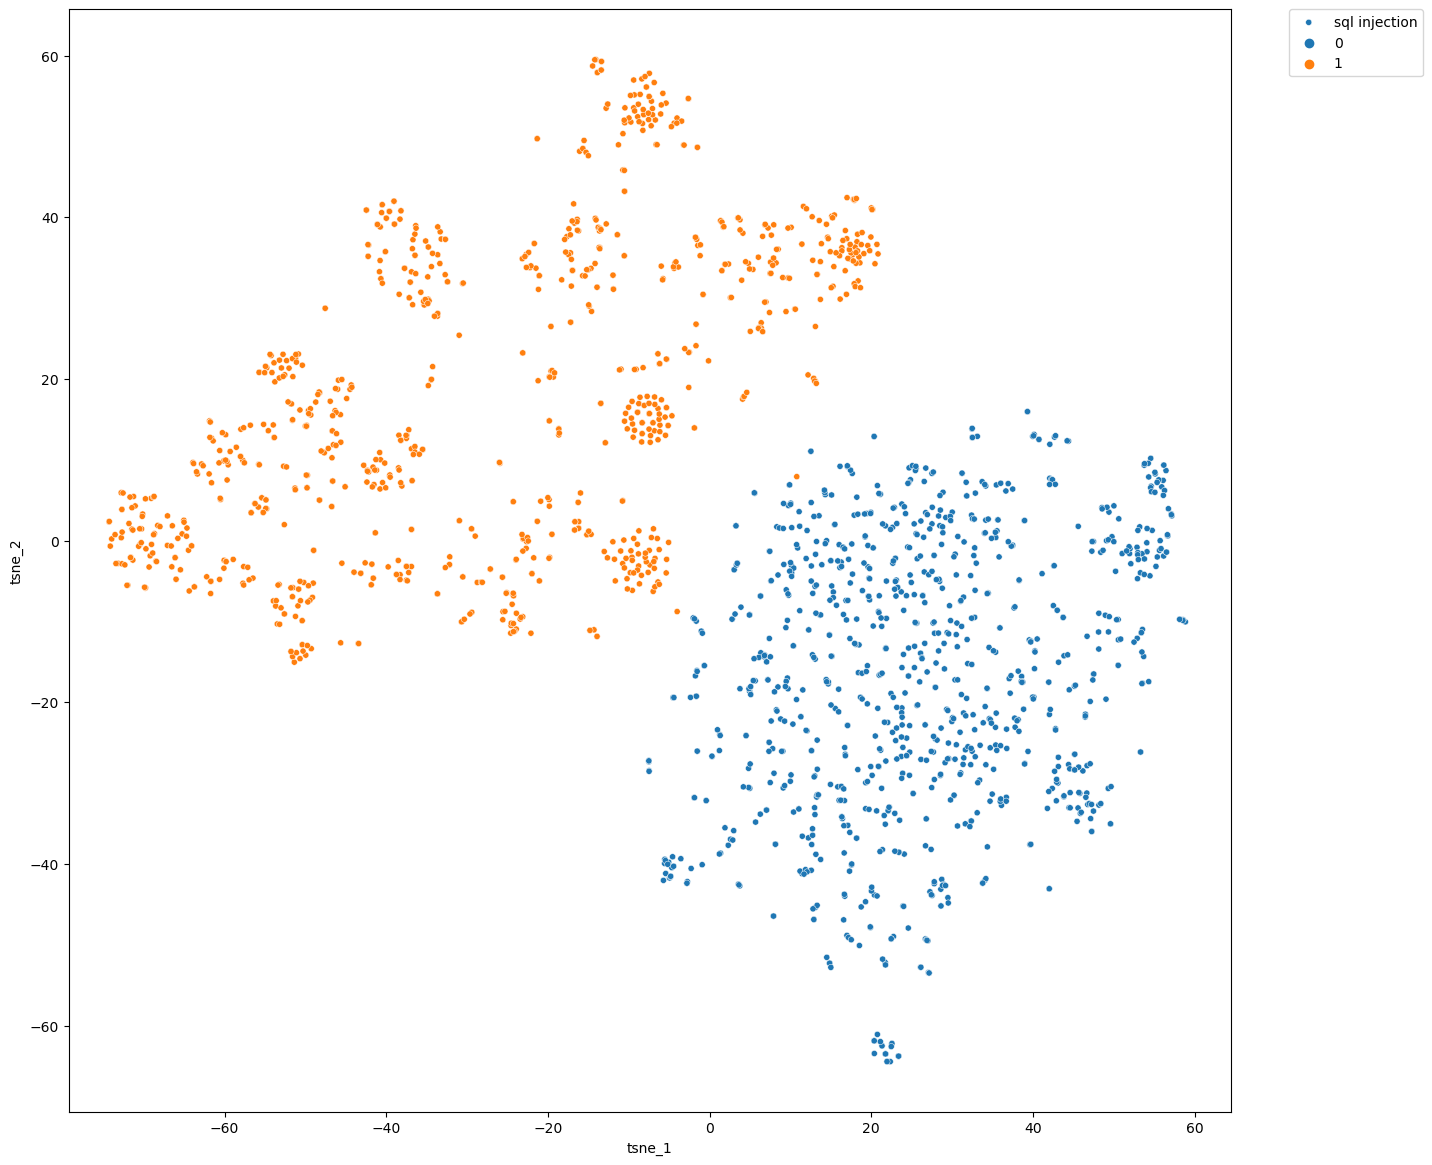

In [64]:
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'sqli': data['sqli'].values})
fig, ax = plt.subplots(1, figsize=(15, 15))

sns.scatterplot(x='tsne_1', y='tsne_2', hue='sqli', label='sql injection', data=tsne_result_df, ax=ax,s=20)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [ ]:
%%capture
pip install tensorboard

In [ ]:
!pip uninstall tensorflow

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.add_embedding(outputs, metadata=data['is_sql'].tolist())